In this notebook, I am projecting NHL skater and goalie stats for the 2024-2025 season, using PyTorch and deep learning. Although this does not take into account the full scope of factors, such as teammate quality, zone deployment, injuries, and other factors, hopefully it still gives solid predictions.

I am not taking into account upcoming rookies, and not projecting players for the 2023-2024 season that did not meet a certain game threshold, regardless of reason. Additionally, some players will also retire or have had other circumstances, but these players will still be projected regardless. In some time, we can see how well these predictions did!

Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score
import os
import psycopg2
from psycopg2.extras import execute_batch

Defining a function to load the data from specified file path (.xlsx created from webscraper).

In [2]:
# Load .xlsx scraped data from specified file path
def load_data(file_path):
    df = pd.concat(
        {sheet: pd.read_excel(file_path, sheet_name=sheet)
         for sheet in pd.ExcelFile(file_path).sheet_names},
        axis=0, names=['Season', 'Row']
    ).reset_index(level=0).rename(columns={'Season': 'Season'})
    print(f"Loaded data shape: {df.shape}")
    return df

Here, we define functions to preprocess the data. First, we filter out players who have under 25 games played. Second, we calculate the fantasy points value. There are a lot of variations, but I am using hits here as the metric, which usually gives a bit more weight to grinder type players instead of the top of the lineup guys. Next, we define two functions to clean some of the data columns, which are those formatted with a '%' symbol, and time columns formatted with a ':'. Lastly, we create the lagging features to indicate past performance, and then normalize the data.

In [3]:
# Remove players under minimum games from dataframe
def filter_data(df, min_games=25):
    df = df[df['GP'] >= min_games]
    df['Season'] = pd.Categorical(df['Season']).codes
    return df

# This function calculates the fantasy points of a skater in a given season - the formula can be modified to preference, this is just the one I have went for
def calculate_fantasy_points(df):
    df['FantasyPoints'] = (
        df['G'] * 3 + 
        df['A'] * 2 + 
        df['SHOTS'] * 0.5 + 
        df['+/-'] * 1 + 
        df['PPP'] * 0.5 +
        df['HITS'] * 0.25
    )
    df['FantasyPoints/G'] = df['FantasyPoints'] / df['GP']
    return df

# Drop '%' symbol in particular columns
def convert_percentage_columns(df, columns):
    for column in columns:
        df[column] = df[column].str.rstrip('%').astype(float) / 100
    return df

# Convert formatted time columns into decimal format
def convert_time_to_float(df, time_columns):
    for col in time_columns:
        df[col] = df[col].apply(lambda x: sum(float(t) * 60 ** i for i, t in enumerate(reversed(str(x).split(':')))) / 60)
    return df

# Create the lagging feature columns
def create_features(df):
    # Create lag features
    lag_columns = ['GP', 'G', 'A', 'P', 'PIM', '+/-', 'TOI', 'ES', 'PP',
                        'SH', 'ESG', 'PPG', 'SHG', 'ESA', 'PPA', 'SHA',
                        'ESP', 'PPP', 'SHP', 'PPP%', 'G/60', 'A/60',
                        'P/60', 'ESG/60', 'ESA/60', 'ESP/60', 'PPG/60',
                        'PPA/60', 'PPP/60', 'G/GP', 'A/GP', 'P/GP', 'SHOTS',
                        'SH%', 'HITS', 'FantasyPoints/G']
    for col in lag_columns:
        df[f'{col}_last_season'] = df.groupby('Name')[col].shift(1)
        df[f'{col}_2seasons_ago'] = df.groupby('Name')[col].shift(2)
    
    # Calculate year-over-year changes
    for col in lag_columns:
        df[f'{col}_yoy_change'] = df[col] - df[f'{col}_last_season']
    
    return df

# Adds lagging column features created by create_features to the total features, and then normalizes them
def create_preprocessor():
    numeric_features = ['Season', 'Age', 'GP', 'G', 'A', 'P', 'PIM', '+/-', 'TOI',
                        'ES', 'PP', 'SH', 'ESG', 'PPG', 'SHG',
                        'ESA', 'PPA', 'SHA', 'ESP', 'PPP', 'SHP',
                        'PPP%', 'G/60', 'A/60', 'P/60', 'ESG/60',
                        'ESA/60', 'ESP/60', 'PPG/60', 'PPA/60', 'PPP/60',
                        'G/GP', 'A/GP', 'P/GP', 'SHOTS', 'SH%', 'HITS']
    
    lag_columns = ['GP', 'G', 'A', 'P', 'PIM', '+/-', 'TOI', 'ES', 'PP',
                        'SH', 'ESG', 'PPG', 'SHG', 'ESA', 'PPA', 'SHA',
                        'ESP', 'PPP', 'SHP', 'PPP%', 'G/60', 'A/60',
                        'P/60', 'ESG/60', 'ESA/60', 'ESP/60', 'PPG/60',
                        'PPA/60', 'PPP/60', 'G/GP', 'A/GP', 'P/GP', 'SHOTS',
                        'SH%', 'HITS', 'FantasyPoints/G']
    for col in lag_columns:
        numeric_features.extend([f'{col}_last_season', f'{col}_2seasons_ago', f'{col}_yoy_change'])
    
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
        ])
    
    return preprocessor

Here, we define the model architecture and dataset. The NHLDataset class is basically just used to structure the input and output data types in a way that PyTorch can use it. For the NHLSkaterModel, this is a custom feedforward neural network. Originally, I was going to use a type of LTSM design, but I just incorporated new features instead, these being the lagging features of the past couple of seasons. I consulted LLMs on a simple yet effective neural network in PyTorch, and this is what it came up with. Additionally, dropout and batch normalization are added to prevent overfitting of the network.

In [4]:
class NHLDataset(Dataset):
    def __init__(self, X, y=None):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32) if y is not None else None

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is not None:
            return self.X[idx], self.y[idx]
        return self.X[idx]

class NHLSkaterModel(nn.Module):
    def __init__(self, input_size, hidden_sizes=[256, 128, 64], dropout_rate=0.3):
        super(NHLSkaterModel, self).__init__()
        layers = []
        prev_size = input_size
        for hidden_size in hidden_sizes:
            layers.extend([
                nn.Linear(prev_size, hidden_size),
                nn.ReLU(),
                nn.BatchNorm1d(hidden_size),
                nn.Dropout(dropout_rate)
            ])
            prev_size = hidden_size
        layers.append(nn.Linear(prev_size, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x).squeeze()

Here, we define a model to train the function. The default values for the arguments are the hyperparameters I decided to go with when I was happy with model performance. I manually tested hyperparameter combinations, and once I found a result I was happy with, set them as the default values, but of course you can play around with them if desired. I also implemented early stopping to avoid overfitting.

In [5]:
def train_model(X, y, epochs=100, batch_size=32, learning_rate=0.0001, weight_decay=1e-5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    preprocessor = create_preprocessor()
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)
    
    train_dataset = NHLDataset(X_train_processed, y_train.values)
    test_dataset = NHLDataset(X_test_processed, y_test.values)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = NHLSkaterModel(input_size=X_train_processed.shape[1]).to(device)
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=20, factor=0.5, verbose=True)
    
    best_mae = float('inf')
    best_model = None
    patience = 50
    patience_counter = 0
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()
        
        model.eval()
        val_loss = 0.0
        predictions = []
        actuals = []
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                val_loss += criterion(outputs, batch_y).item()
                predictions.extend(outputs.cpu().numpy())
                actuals.extend(batch_y.cpu().numpy())
        
        mae = mean_absolute_error(actuals, predictions)
        r2 = r2_score(actuals, predictions)
        
        if mae < best_mae:
            best_mae = mae
            best_model = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
        
        scheduler.step(val_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss/len(train_loader):.4f}, '
                  f'Val Loss: {val_loss/len(test_loader):.4f}, MAE: {mae:.4f}, R²: {r2:.4f}')
        
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs")
            break
    
    model.load_state_dict(best_model)
    print(f"Best Model Performance - MAE: {best_mae:.4f}")
    
    return model, preprocessor

Here, we define a function to make projections for the next season, which in this case, is projecting 2024-2025 fantasy output using the 2023-2024 players.

In [6]:
def make_projections(model, preprocessor, df):
    latest_season = df['Season'].max()
    projection_data = df[df['Season'] == latest_season].copy()
    
    features = [col for col in df.columns if col not in ['Name', 'Team', 'Pos', 'FantasyPoints/G']]
    X_proj = projection_data[features]
    X_proj['Season'] += 1
    
    X_proj_processed = preprocessor.transform(X_proj)
    projection_dataset = NHLDataset(X_proj_processed)
    projection_loader = DataLoader(projection_dataset, batch_size=32, shuffle=False)
    
    model.eval()
    device = next(model.parameters()).device
    
    with torch.no_grad():
        projections = []
        for batch_X in projection_loader:
            batch_X = batch_X.to(device)
            outputs = model(batch_X)
            projections.extend(outputs.cpu().numpy())
    
    projection_df = projection_data[['Name', 'Team', 'Pos']].copy()
    projection_df['ProjectedFantasyPoints/G'] = np.round(projections, 2)
    projection_df['ProjectedTotalFantasyPoints'] = np.round(projection_df['ProjectedFantasyPoints/G'] * 82, 2)
    
    return projection_df

Here, we define some functions to plot feature importance and model performance.

In [7]:
def visualize_feature_importance(model, preprocessor, X):
    feature_names = preprocessor.get_feature_names_out()
    importance = abs(model.model[0].weight.data.cpu().numpy()).mean(axis=0)
    
    feature_importance = pd.DataFrame({'feature': feature_names, 'importance': importance})
    feature_importance = feature_importance.sort_values('importance', ascending=False).head(20)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance)
    plt.title('Top 20 Feature Importance for Skaters')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
def visualize_model_performance(model, preprocessor, X, y):
    X_processed = preprocessor.transform(X)
    dataset = NHLDataset(X_processed, y.values)
    data_loader = DataLoader(dataset, batch_size=32, shuffle=False)
    
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for batch_X, batch_y in data_loader:
            batch_X = batch_X.to(next(model.parameters()).device)
            outputs = model(batch_X)
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(batch_y.numpy())
    
    mae = mean_absolute_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(actuals, predictions, alpha=0.5)
    plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'r--', lw=2)
    plt.xlabel('Actual Fantasy Points/G')
    plt.ylabel('Predicted Fantasy Points/G')
    plt.title(f'Predicted vs Actual Fantasy Points/G for Skaters\nMAE: {mae:.2f}, R²: {r2:.2f}')
    plt.show()

Here is the main function where we call all of the previous functions and see how the model does! We also save the resulting Fantasy Points and Projected Fantasy Points into our postgres database for 2023-2024 skaters (I already altered the table with the new columns).

Loaded data shape: (16920, 50)


/tmp/ipykernel_4009/2743772514.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Season'] = pd.Categorical(df['Season']).codes
/tmp/ipykernel_4009/2743772514.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_yoy_change'] = df[col] - df[f'{col}_last_season']
/tmp/ipykernel_4009/2743772514.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1)

Epoch [10/100], Train Loss: 0.7272, Val Loss: 0.2713, MAE: 0.3694, R²: 0.7629
Epoch [20/100], Train Loss: 0.4485, Val Loss: 0.2548, MAE: 0.3546, R²: 0.7773
Epoch [30/100], Train Loss: 0.3773, Val Loss: 0.2356, MAE: 0.3479, R²: 0.7941
Epoch [40/100], Train Loss: 0.3461, Val Loss: 0.2354, MAE: 0.3432, R²: 0.7943
Epoch [50/100], Train Loss: 0.3249, Val Loss: 0.2295, MAE: 0.3438, R²: 0.7994
Epoch [60/100], Train Loss: 0.3123, Val Loss: 0.2409, MAE: 0.3504, R²: 0.7895
Epoch [70/100], Train Loss: 0.2946, Val Loss: 0.2324, MAE: 0.3427, R²: 0.7969
Epoch [80/100], Train Loss: 0.2922, Val Loss: 0.2364, MAE: 0.3465, R²: 0.7934
Epoch [90/100], Train Loss: 0.2843, Val Loss: 0.2349, MAE: 0.3530, R²: 0.7947
Epoch [100/100], Train Loss: 0.2773, Val Loss: 0.2464, MAE: 0.3510, R²: 0.7847
Best Model Performance - MAE: 0.3412


/tmp/ipykernel_4009/245278014.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_proj['Season'] += 1


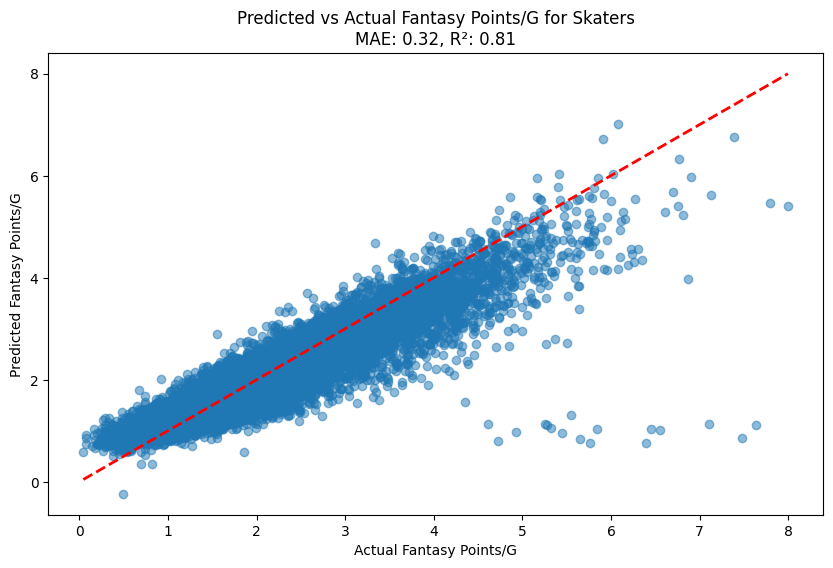

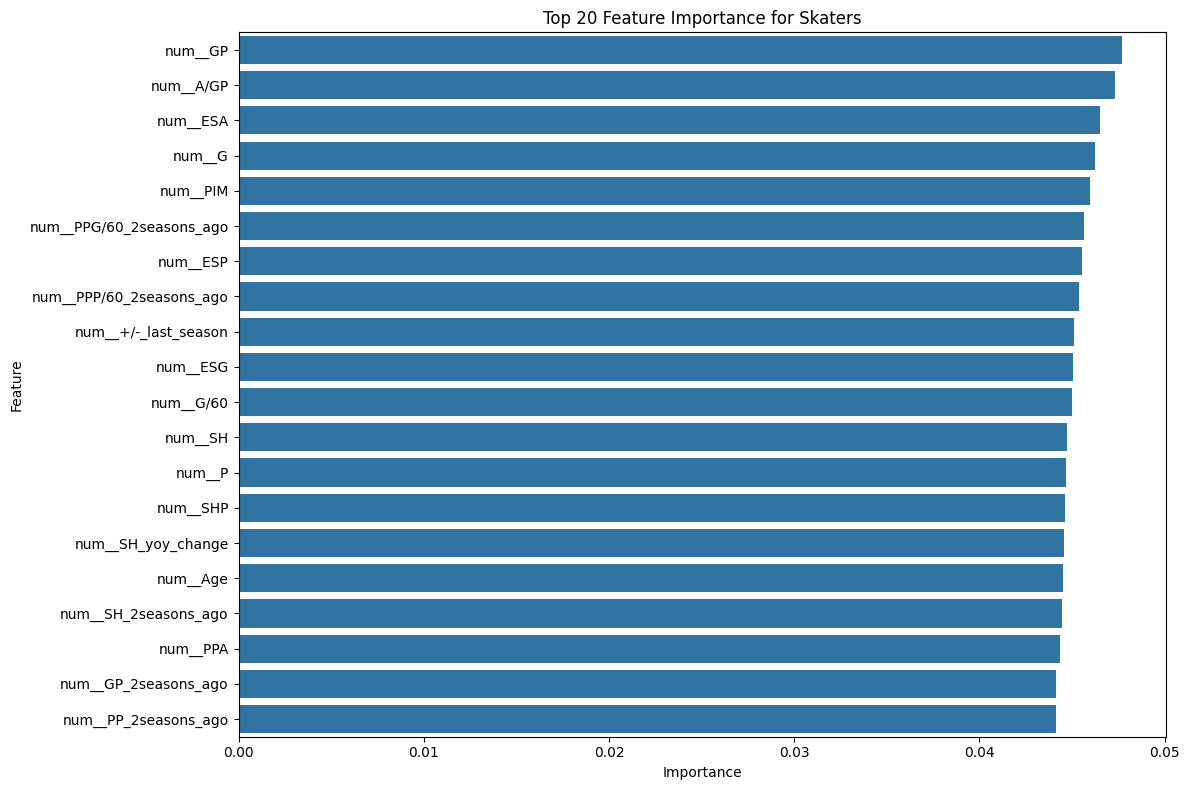

Changes committed to database


In [14]:
def main():
    skater_file_path = '/mnt/c/Users/killi/Documents/Fantasy-Hockey-App/backend/webscraper/nhl_skater_stats.xlsx'
    df_skaters = load_data(skater_file_path)
    df_skaters = filter_data(df_skaters)
    df_skaters = calculate_fantasy_points(df_skaters)

    percent_columns = ['SH%', 'PPP%']
    df_skaters = convert_percentage_columns(df_skaters, percent_columns)
    time_columns = ['TOI', 'ES', 'PP', 'SH']
    df_skaters = convert_time_to_float(df_skaters, time_columns)

    df_skaters = create_features(df_skaters)

    features = [col for col in df_skaters.columns if col not in ['Name', 'Team', 'Pos', 'FantasyPoints/G']]
    X_skaters = df_skaters[features]
    y_skaters = df_skaters['FantasyPoints/G'].shift(-1)

    # Remove rows where the target is NaN (last season for players who don't have multiple past seasons yet)
    mask_skaters = y_skaters.notna()
    X_skaters = X_skaters[mask_skaters]
    y_skaters = y_skaters[mask_skaters]

    model, preprocessor = train_model(X_skaters, y_skaters)
    projections_skaters = make_projections(model, preprocessor, df_skaters)

    visualize_model_performance(model, preprocessor, X_skaters, y_skaters)
    visualize_feature_importance(model, preprocessor, X_skaters)
    #projections_skaters.to_csv('skater_projections.csv', index=False)

    db_username = os.getenv('DB_USERNAME')
    db_password = os.getenv('DB_PASSWORD')
    connection = psycopg2.connect(
        dbname='fantasy_hockey',
        user=db_username, # export DB_USERNAME='your_username'
        password=db_password, # export DB_PASSWORD='your_password'
        host='localhost'
    )
    cursor = connection.cursor()

    current_season = 18  # Numeric encoding for the 2023-2024 season
    current_season_str = '2023-24'
    season_mapping = {i: f"{2005+i}-{str(2006+i)[-2:]}" for i in range(19)}

    current_players = set(df_skaters[df_skaters['Season'] == current_season]['Name'])

    data_to_update = []
    for index, row in df_skaters.iterrows():
        name = row['Name']
        season_num = row['Season']
        
        season = season_mapping[season_num]
        
        if season_num == current_season:
            fantasy_points = round(float(row['FantasyPoints']), 2)
            projected_points = round(float(projections_skaters.loc[projections_skaters['Name'] == name, 'ProjectedTotalFantasyPoints'].values[0]), 2) if name in projections_skaters['Name'].values else 0.0
            data_to_update.append((fantasy_points, projected_points, name, season))

    query = """
        UPDATE skater_stats
        SET fantasypoints = %s,
            projectedfantasypoints = %s
        WHERE Name = %s AND Season = %s
    """
    try:
        execute_batch(cursor, query, data_to_update)
    except Exception as e:
        print(f"Error during batch update: {e}")
        connection.rollback()
    else:
        connection.commit()

    # Set fantasy points and projected fantasy points to 0 for players not in the dataframe for the current season (< 25 games in 2023-2024)
    cleanup_query = """
        UPDATE skater_stats
        SET fantasypoints = 0, projectedfantasypoints = 0
        WHERE Season = %s AND Name NOT IN %s
    """
    cursor.execute(cleanup_query, (current_season_str, tuple(current_players)))

    # Set fantasy points and projected fantasy points to 0 for all players where season is not 2023-2024
    cleanup_previous_seasons_query = """
        UPDATE skater_stats
        SET fantasypoints = 0, projectedfantasypoints = 0
        WHERE Season != %s
    """
    cursor.execute(cleanup_previous_seasons_query, (current_season_str,))

    connection.commit()
    print("Changes committed to database")
    cursor.close()
    connection.close()

if __name__ == "__main__":
    main()


Based on the evaluation metrics, this model performed quite solidly. With more advanced stats, I think the projections would be even better. It will be interesting to see how these projections play out as the 2024-2025 season unfolds!